# 49ers Play-Calling EDA (Shanahan Era)

This notebook explores the play-calling tendencies of Kyle Shanahan from 2017-2025.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss

In [3]:
def load_and_process_data(filepath):
    df = pd.read_csv(filepath)

    # 49ers offensive plays only
    df = df[df['is_49ers'] == True].copy()

    # columns to numeric
    cols_to_numeric = ['quarter', 'down', 'ydstogo', 'location_csk', 'away_score', 'home_score']
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing essential data
    df = df.dropna(subset=['quarter', 'down', 'ydstogo', 'location_csk', 'play_type'])

    # Yards to Endzone
    df['yards_to_endzone'] = df['location_csk']

    # Score Differential
    def get_score_diff(row):
        game_id = str(row['game_id'])
        home_team = game_id[-3:]
        is_home = (home_team == 'sfo')
        return (row['home_score'] - row['away_score']) if is_home else (row['away_score'] - row['home_score'])

    df['score_differential'] = df.apply(get_score_diff, axis=1)

    # Time Remaining
    def parse_time(t_str):
        try:
            if pd.isna(t_str): return None
            parts = str(t_str).split(':')
            return int(parts[0]) * 60 + int(parts[1])
        except:
            return None

    df['seconds_in_qtr'] = df['time_remaining'].apply(parse_time)
    df = df.dropna(subset=['seconds_in_qtr'])

    # Game Seconds Remaining
    df['game_seconds_remaining'] = (4 - df['quarter']) * 900 + df['seconds_in_qtr']
    df.loc[df['quarter'] > 4, 'game_seconds_remaining'] = df['seconds_in_qtr']

    # Target
    df['target'] = df['play_type'].map({'run': 0, 'pass': 1})
    df = df.dropna(subset=['target'])


    # Season
    def get_season(row):
        game_id = str(row['game_id'])
        year = int(game_id[:4])
        month = int(game_id[4:6])
        # If Jan/Feb, it belongs to the previous year's season
        if month <= 2:
            return year - 1
        return year

    df['season'] = df.apply(get_season, axis=1)

    return df

df_processed = load_and_process_data('49ers_plays.csv')



In [4]:
features = ['down', 'ydstogo', 'yards_to_endzone', 'score_differential', 'game_seconds_remaining']
target = 'target'

# Train: < 2024
# Validation: 2024
# Test: 2025
train_df = df_processed[df_processed['season'] < 2024].copy()
val_df = df_processed[df_processed['season'] == 2024].copy()
test_df = df_processed[df_processed['season'] == 2025].copy()

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Train Set (2017-2023): {len(X_train)} plays")
print(f"Val Set (2024): {len(X_val)} plays")
print(f"Test Set (2025): {len(X_test)} plays")

Train Set (2017-2023): 7410 plays
Val Set (2024): 949 plays
Test Set (2025): 838 plays


Training Logistic Regression...


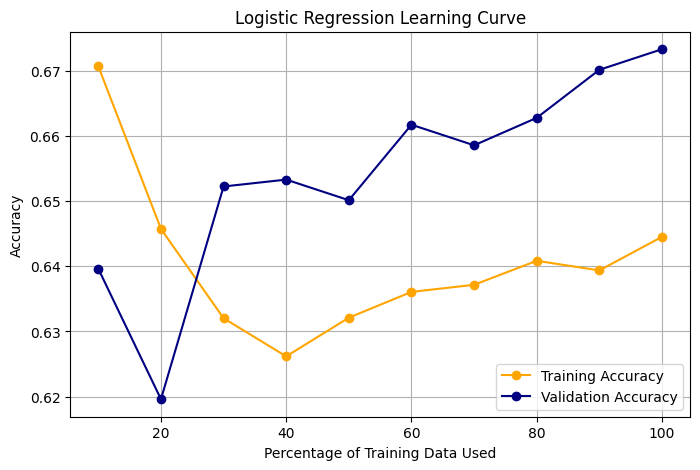

In [7]:
lr_model = LogisticRegression(max_iter=2000, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

print("Training Logistic Regression...")
for size in train_sizes:

    subset_n = int(len(X_train) * size)
    X_sub = X_train.iloc[:subset_n]
    y_sub = y_train.iloc[:subset_n]

    lr_model.fit(X_sub, y_sub)

    train_scores.append(accuracy_score(y_sub, lr_model.predict(X_sub)))
    val_scores.append(accuracy_score(y_val, lr_model.predict(X_val)))


plt.figure(figsize=(8, 5))
plt.plot(train_sizes * 100, train_scores, 'o-', label='Training Accuracy', color='orange')
plt.plot(train_sizes * 100, val_scores, 'o-', label='Validation Accuracy', color='navy')
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Training Random Forest...


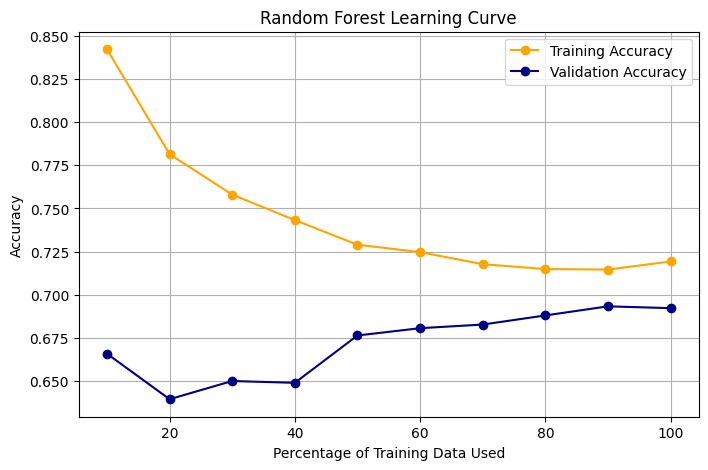

In [14]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)

train_scores = []
val_scores = []
train_sizes = np.linspace(0.1, 1.0, 10)

print("Training Random Forest...")
for size in train_sizes:
    subset_n = int(len(X_train) * size)
    X_sub = X_train.iloc[:subset_n]
    y_sub = y_train.iloc[:subset_n]

    rf_model.fit(X_sub, y_sub)
    train_scores.append(accuracy_score(y_sub, rf_model.predict(X_sub)))
    val_scores.append(accuracy_score(y_val, rf_model.predict(X_val)))


plt.figure(figsize=(8, 5))
plt.plot(train_sizes * 100, train_scores, 'o-', label='Training Accuracy', color='orange')
plt.plot(train_sizes * 100, val_scores, 'o-', label='Validation Accuracy', color='navy')
plt.title('Random Forest Learning Curve')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Training Gradient Boosting...


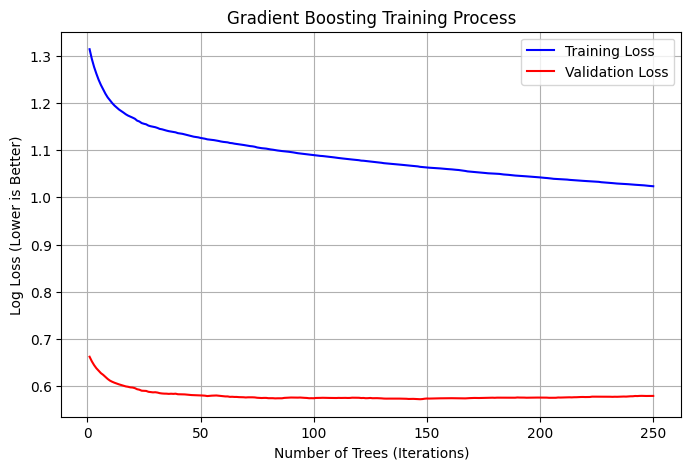

In [21]:
gb_model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=3, random_state=42)

print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train)

val_loss = []
for y_pred_proba in gb_model.staged_predict_proba(X_val):
    val_loss.append(log_loss(y_val, y_pred_proba))

train_loss = gb_model.train_score_

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 251), train_loss, label='Training Loss', color='blue')
plt.plot(np.arange(1, 251), val_loss, label='Validation Loss', color='red')
plt.title('Gradient Boosting Training Process')
plt.xlabel('Number of Trees (Iterations)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

--- Final Test Results (2025 Season) ---
Accuracy: 70.53%

Classification Report:
              precision    recall  f1-score   support

         Run       0.60      0.60      0.60       306
        Pass       0.77      0.77      0.77       532

    accuracy                           0.71       838
   macro avg       0.68      0.68      0.68       838
weighted avg       0.71      0.71      0.71       838



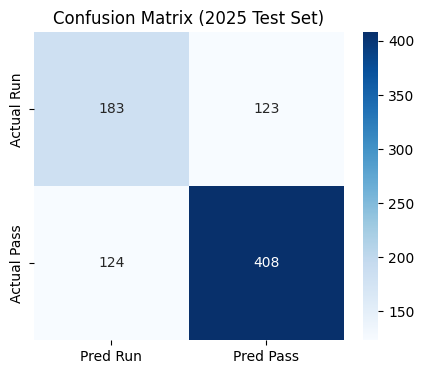

In [22]:
final_preds = gb_model.predict(X_test)
test_acc = accuracy_score(y_test, final_preds)

print(f"--- Final Test Results (2025 Season) ---")
print(f"Accuracy: {test_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds, target_names=['Run', 'Pass']))

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Run', 'Pred Pass'],
            yticklabels=['Actual Run', 'Actual Pass'])
plt.title('Confusion Matrix (2025 Test Set)')
plt.show()

In [37]:
def predict_play_cli():
    """
    Predicts play type based on game situation.
    """
    print('Enter Game State:')
    down = input('Down: ')
    dist = input('Yards to Go: ')
    yardline = input('Yards to Endzone: ')
    score_diff = input('Score Differential (relative to): ')
    time_rem_str = input('Time Remaining in Quarter: ')
    qtr = int(input('Quarter: '))
    # Time
    try:
        m, s = map(int, time_rem_str.split(':'))
        sec_in_qtr = m * 60 + s
    except:
        sec_in_qtr = 900

    # Game seconds remaining
    game_sec = (4 - qtr) * 900 + sec_in_qtr
    if qtr > 4: game_sec = sec_in_qtr # OT logic

    input_data = pd.DataFrame([{
        'down': down,
        'ydstogo': dist,
        'yards_to_endzone': yardline,
        'score_differential': score_diff,
        'game_seconds_remaining': game_sec
    }])

    prob = gb_model.predict_proba(input_data)[0]
    pred_idx = gb_model.predict(input_data)[0]

    play_call = "PASS" if pred_idx == 1 else "RUN"
    confidence = prob[pred_idx]

    return play_call, confidence


p, c = predict_play_cli()
print(f"Prediction: {p} ({c:.1%} confidence)")

Enter Game State:
Down: 2
Yards to Go: 1
Yards to Endzone: 25
Score Differential (relative to): 0
Time Remaining in Quarter: 7:00
Quarter: 3
Prediction: RUN (87.2% confidence)
